In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from project import run

# setting display options
%matplotlib inline
pd.set_option('display.width', 4000)
pd.set_option('max_colwidth', 4000)
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 200)
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
my_path = r'./data/insurance.db'

df = run(my_path, nb_exploration=True)

NaN values of "Area" column were imputed.
NaN values of "Education" column were imputed.
NaN values of "Children" column were imputed.
   Education  Salary Area Children     CMV  Claims  Motor  Household  Health  Life  Work_Compensation  Age  Customer_Years
ID                                                                                                                        
1       2.00    2177 1.00     1.00  380.97    0.39   0.57      -0.55   -0.29  0.24              -0.54   34              31
2       2.00     677 4.00     1.00 -131.13    1.12  -1.59       0.96   -0.69  0.00               1.75   21              35


In [3]:
df.head()

,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work_Compensation,Age,Customer_Years
ID,,,,,,,,,,,,,
1,2.00,2177,1.00,1.00,380.97,0.39,0.57,-0.55,-0.29,0.24,-0.54,34,31
2,2.00,677,4.00,1.00,-131.13,1.12,-1.59,0.96,-0.69,0.00,1.75,21,35
3,1.00,2277,3.00,0.00,504.67,0.28,-0.66,0.10,-0.58,1.27,1.57,46,25
4,3.00,1099,4.00,1.00,-16.99,0.99,-0.83,-0.71,1.92,-0.07,-0.24,35,26
5,3.00,1763,4.00,1.00,35.23,0.90,0.30,-0.69,0.20,-0.50,0.09,43,30


In [4]:
df.dtypes

Education            category
Salary                  int32
Area                 category
Children             category
CMV                   float64
Claims                float64
Motor                 float64
Household             float64
Health                float64
Life                  float64
Work_Compensation     float64
Age                     int32
Customer_Years          int32
dtype: object

In [5]:
df.isna().any().any()

False

In [6]:
premiums_cols = ["Motor", "Household", "Health", "Life", "Work_Compensation"]
categorical_cols = ["Area", "Education", "Children"]
df.columns

Index(['Education', 'Salary', 'Area', 'Children', 'CMV', 'Claims', 'Motor', 'Household', 'Health', 'Life', 'Work_Compensation', 'Age', 'Customer_Years'], dtype='object')

In [7]:
# Divide the variables into Value / Engage and Consumption / Affinity

ValueEngage = df[['Age',
               'Education',
               'Salary',
               'Area',
               'Children',
               'CMV',
               'Claims',
               'Customer_Years']]

ConsAff = df.loc[:,[ 'Motor',
               'Household',
               'Health',
               'Life',
               'Work_Compensation']].reindex()

In [8]:
# cols_for_clustering = []
# cols_for_clustering.extend(premiums_cols)
# cols_for_clustering.extend(categorical_cols)

### Pearson correlation

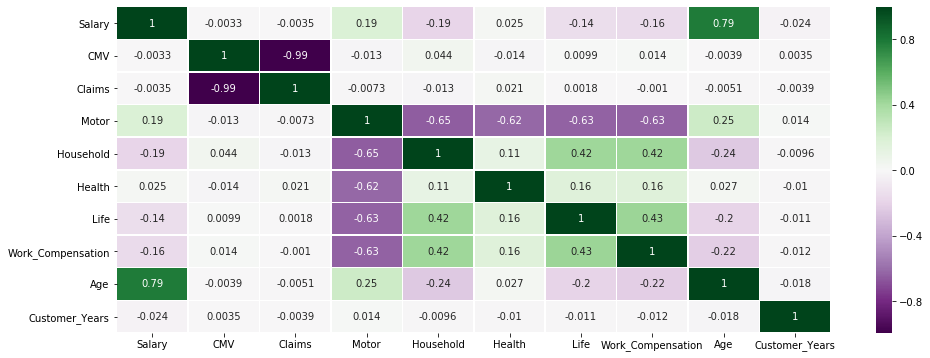

In [9]:
corr = df.corr(method='pearson')

# Obtain Correlation and plot it
plt.figure(figsize=(16,6))

h_map = sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='PRGn', annot=True, linewidths=.5)

#this is fix for matplotlib3.1.1 to ensure the top and bottom rows are not cut off.
# According to: https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986
bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [10]:
# might be handy: https://github.com/joaolcorreia/RFM-analysis

In [11]:
from sklearn.preprocessing import StandardScaler
df[:] = StandardScaler().fit_transform(df[:])

x = df[df.columns.difference(categorical_cols + premiums_cols)].values # excluding categorical columns
x = x[:200] # slice array for faster cluster testing

[0.25630344 0.16278943 0.15338931 0.07915462 0.07722945 0.07601936
 0.04814968 0.04507846 0.04398135 0.03758441 0.01499983 0.00479379
 0.00052686]


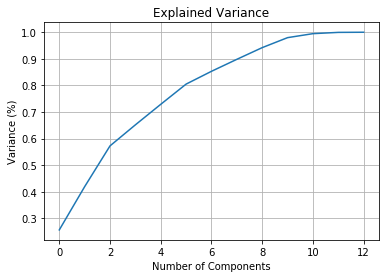

In [12]:
from sklearn.decomposition import PCA

# Fitting the PCA algorithm with our Data
pca = PCA().fit(df)

print(pca.explained_variance_ratio_)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.grid()
plt.show()

9 components explain 94.20951% of the variance. So, we'll use 9 components.

In [13]:
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(df)

principalDf = pd.DataFrame(data = principalComponents, columns = ['pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6',
                                                                  'pc_7', 'pc_8', 'pc_9'])

In [14]:
print('Components: ', pca.components_)
print('Explained Variance: ', pca.explained_variance_)
print('Explained Variance Ratio: ', pca.explained_variance_ratio_)

Components:  [[ 3.46103241e-01  2.21911654e-01 -3.02698454e-03  4.47509550e-02
  -1.92244434e-02  6.57750311e-03  5.00509628e-01 -3.98150581e-01
  -2.13951092e-01 -3.90761719e-01 -3.94796026e-01  2.55217778e-01
   6.28753176e-03]
 [-6.08666499e-04  5.23143572e-01  2.68088680e-02 -5.50973532e-01
  -2.13448677e-02  2.23832473e-02 -1.83344178e-01  4.20530005e-02
   2.84687425e-01  8.72029610e-02  6.54193144e-02  5.40046654e-01
  -3.32921499e-02]
 [ 4.34430983e-03 -2.85267514e-02  8.20660425e-03  1.65783068e-02
  -7.05911843e-01  7.06048715e-01 -1.11095003e-02 -1.83382114e-02
   2.47845799e-02  4.99944721e-03  2.43815851e-03 -2.97835913e-02
  -4.10569479e-03]
 [-3.93819654e-01  2.12842852e-01  3.67992949e-01  2.39467973e-02
  -1.98384324e-02  2.40526322e-02  1.96859763e-01  2.09747186e-01
  -6.99304949e-01  1.56283205e-01  1.43105187e-01  1.65962073e-01
  -1.35711620e-01]
 [-3.95601208e-02  3.57130356e-02 -5.97672603e-01  2.66759430e-02
  -4.46688167e-03  4.12074882e-03  2.50700623e-02  2.

In [15]:
principalDf.head(5)

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9
0,0.24,-1.21,-0.13,-0.30,0.71,-1.07,0.68,0.15,0.63
1,-2.64,-1.76,0.30,0.56,-1.15,0.19,-0.47,-0.02,-1.26
2,-2.15,0.89,-0.25,1.54,0.60,0.01,0.22,0.68,-0.23
3,-0.63,-0.69,0.28,-1.87,-0.43,2.06,0.42,0.26,0.13
4,0.58,-0.88,0.15,-0.34,-0.69,1.05,0.05,0.38,-0.46


In [16]:
# # do we need to show the PCA some how? so I try to do with T-SNE
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
# tsne_pca_results = tsne.fit_transform(principalDf)

# tsne_data = np.vstack((tsne_pca_results.T, principalDf.index)).T

# tsne_df = pd.DataFrame(data=tsne_data, columns = ('Dim_1', 'Dim_2', 'label'))

# sns.FacetGrid(tsne_df, hue='label', height=6).map(plt.scatter, 'Dim_1', 'Dim_2', alpha=.7)
# plt.show()

In [ ]:
# df_subset = df.copy()
# df_subset = df_subset.T
# df_subset['tsne-pca-one'] = tsne_pca_results[:,0]
# df_subset['tsne-pca-two'] = tsne_pca_results[:,1]

# ax = plt.subplot(1,3,3)
# sb.scatterplot(
#     x='tsne-pca-one', y='tsne-pca-one',
#     hue=df.columns,
#     palette=sb.color_palette('hls', 10),
#     data = df_subset,
#     legend = 'full',
#     alpha = 0.3
# )

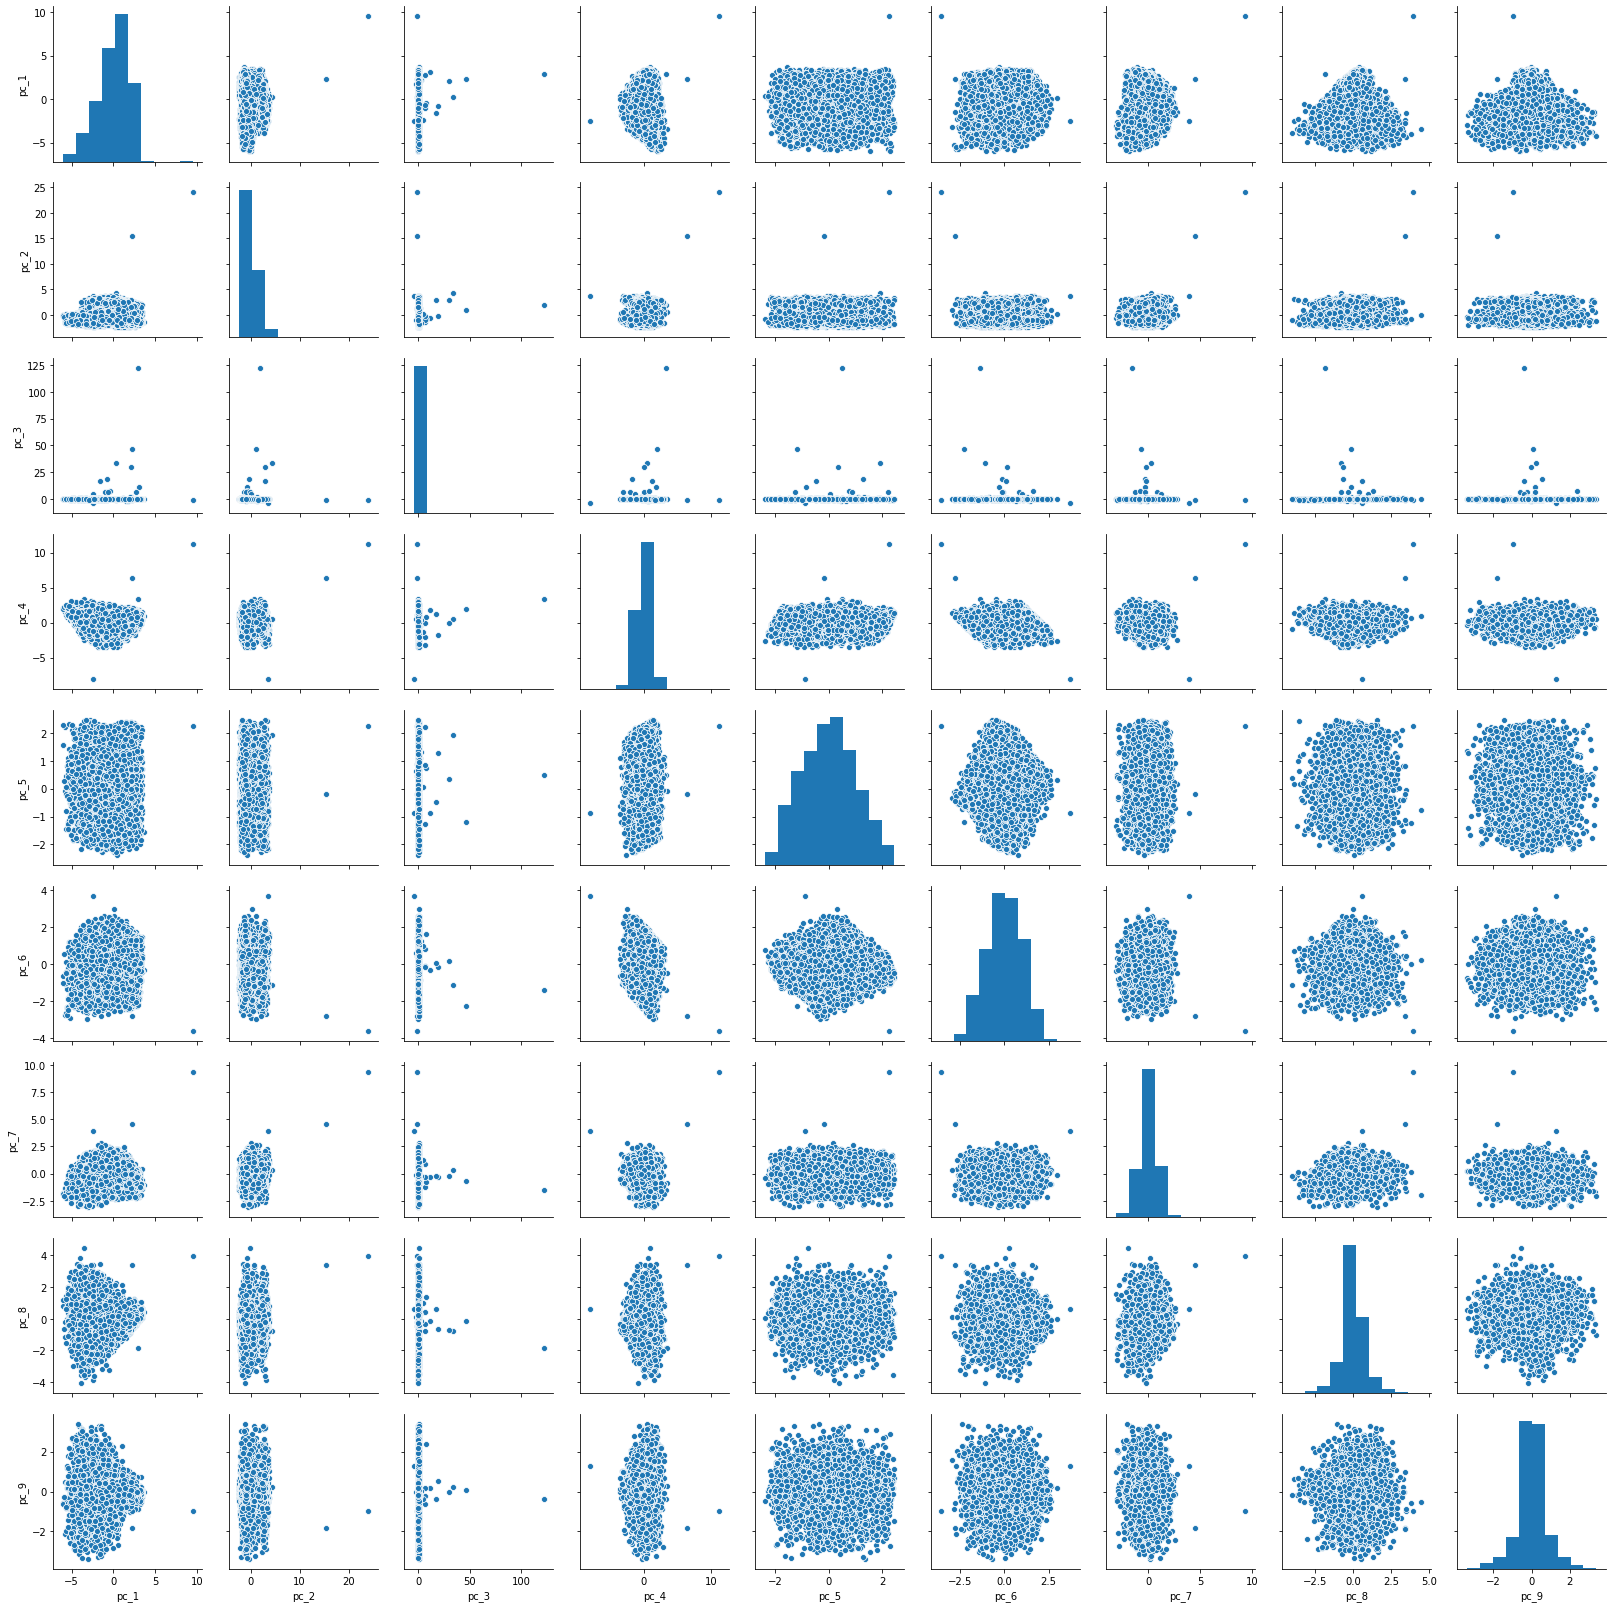

In [17]:
sns.pairplot(principalDf)
plt.show()

In [18]:
# only if PCA is 2 components:
# plt.scatter(principalDf.iloc[:, 0], principalDf.iloc[:, 1])
# # plt.scatter(principalComponents[:,0], principalComponents[:,1])
# plt.show()

In [19]:
# principalDf = StandardScaler().fit_transform(principalDf[:])

# x = principalDf.values

# x.shape

In [20]:
from utils.preprocessing import remove_outliers, handle_nans

_, pca_outliers = remove_outliers(principalDf, principalDf.columns)
print(pca_outliers, "\n")

i = 1

while pca_outliers.any() == True: # checking non-zero existence
    print(f"Iteration #{i}...")
    principalDf, pca_outliers = remove_outliers(principalDf, pca_outliers[pca_outliers > 0].index.tolist())
    principalDf = handle_nans(principalDf, pca_outliers[pca_outliers > 0].index.tolist())
    principalDf[:] = StandardScaler().fit_transform(principalDf[:])
    i += 1

print("No outliers after standardization.")

pc_1     16
pc_2      2
pc_3     12
pc_4     23
pc_5      0
pc_6      3
pc_7     36
pc_8    177
pc_9    184
dtype: int64 

Iteration #1...
Iteration #2...
Iteration #3...
Iteration #4...
Iteration #5...
Iteration #6...
Iteration #7...
Iteration #8...
Iteration #9...
Iteration #10...
Iteration #11...
Iteration #12...
Iteration #13...
Iteration #14...
Iteration #15...
Iteration #16...
Iteration #17...
No outliers after standardization.


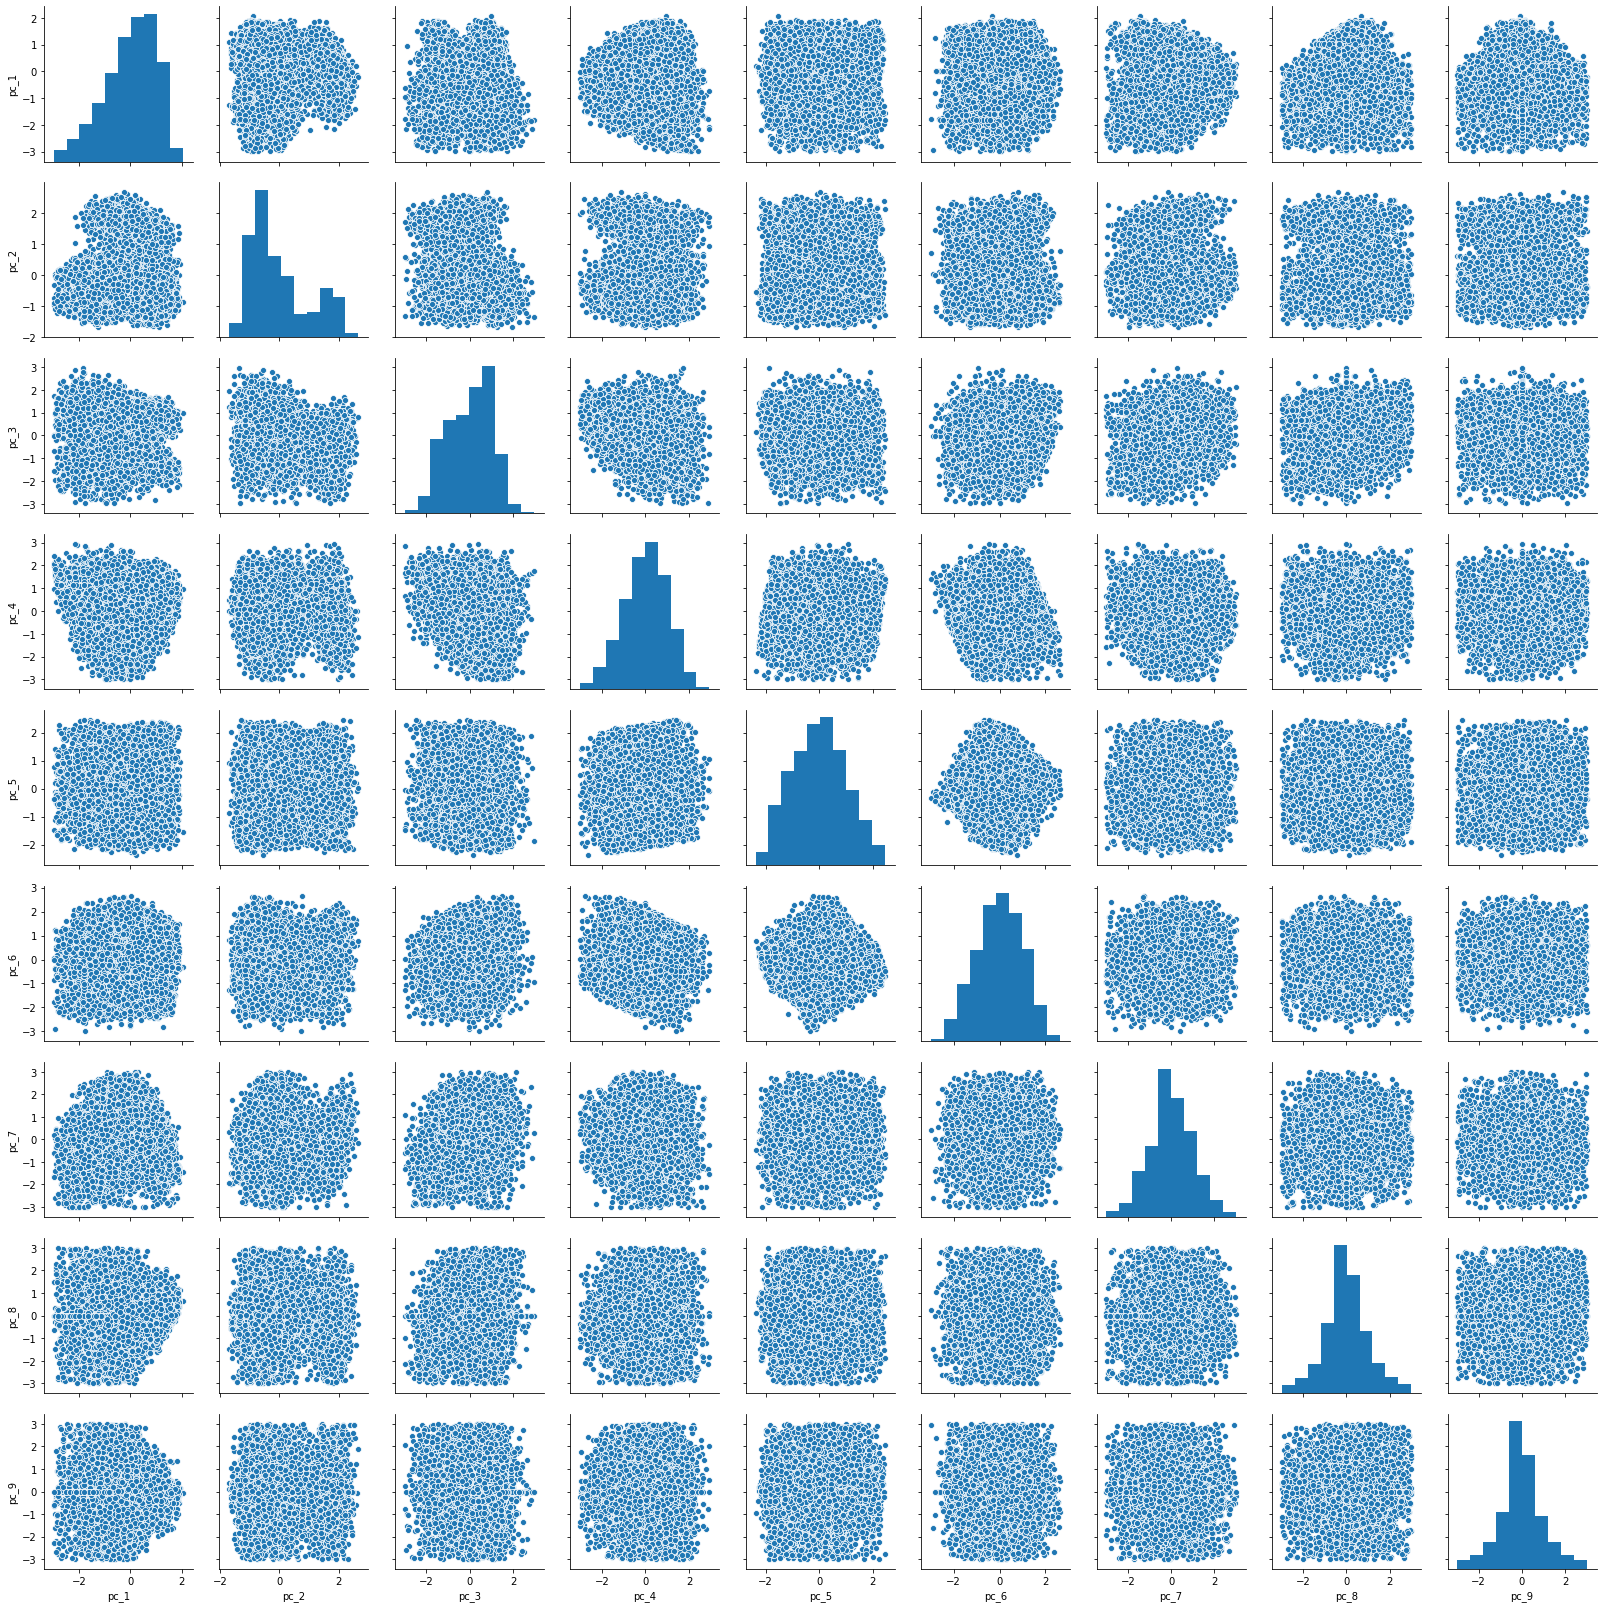

In [21]:
sns.pairplot(principalDf)
plt.show()

[0.1593892  0.1221712  0.1148841  0.11336269 0.11202846 0.1104993
 0.10647797 0.09965875 0.06152832]


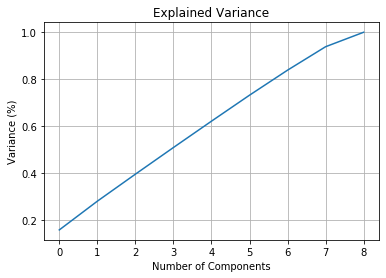

In [22]:
# Fitting the PCA algorithm with our Data
pca = PCA().fit(principalDf)

print(pca.explained_variance_ratio_)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.grid()
plt.show()

In [23]:
pca = PCA(n_components=2)
secondComponents = pca.fit_transform(principalDf)

secondDf = pd.DataFrame(data = secondComponents, columns = ['pc_1', 'pc_2'])

In [24]:
x = secondComponents

x.shape

(10296, 2)

### K-Means Clustering

In [25]:
from sklearn.cluster import KMeans

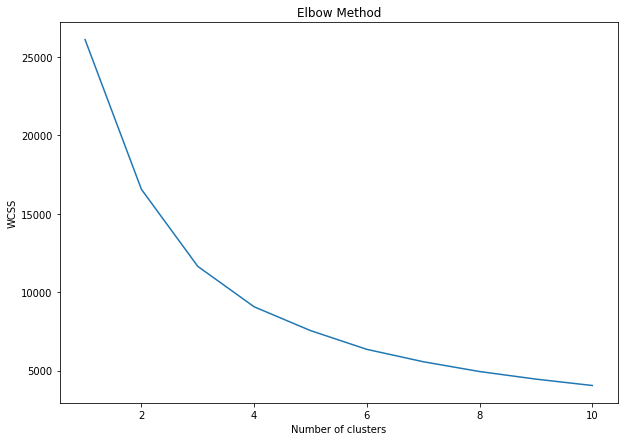

In [26]:
plt.figure(figsize=(10, 7))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [27]:
best_number_of_clusters = 3

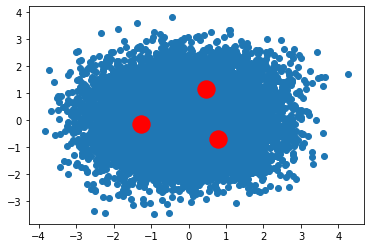

In [28]:
kmeans = KMeans(n_clusters=best_number_of_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(x)
plt.scatter(x[:,0], x[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [29]:
# Awful results. However, agglomerative clustering seems to be better.

### Agglomerative Clustering

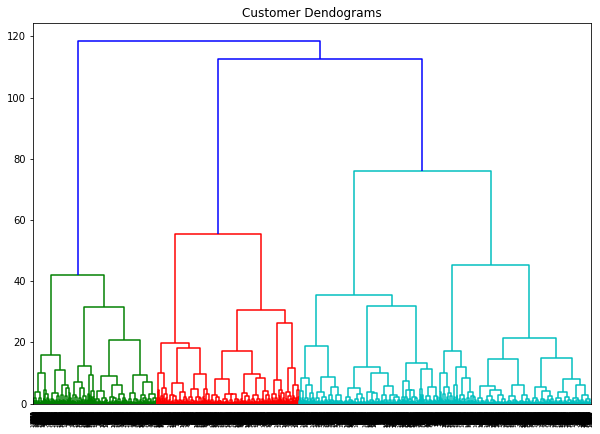

In [30]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(x, method='ward'))

In [31]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 4

cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
cluster.fit_predict(x)

array([0, 1, 3, ..., 3, 1, 3], dtype=int64)

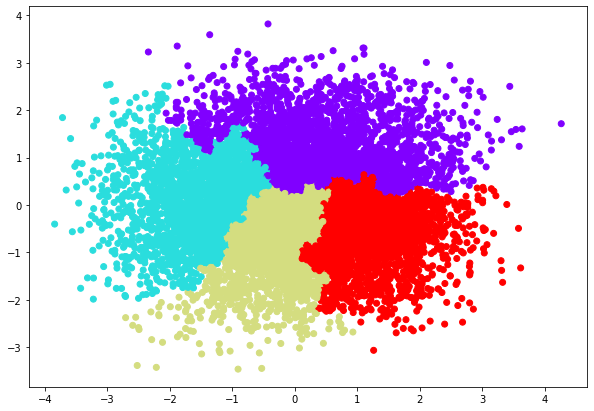

In [32]:
plt.figure(figsize=(10, 7))
plt.scatter(x[:,0], x[:,1], c=cluster.labels_, cmap='rainbow')

plt.show()